In [1]:
import pandas as pd
import numpy as np
import ast
import re
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from model import *

In [2]:
df = pd.read_pickle('data/model_data_window_300_space_50.pkl')
df.head()

,id,sig_array,activity_name,subject_id,dataset
0,0,"[[-0.1832595, -0.2076941, -0.53145254, 9.77168...",squats,0,mmfit
1,1,"[[1.4453067, -1.6517789, -1.4514153, 1.4441968...",squats,0,mmfit
2,2,"[[1.3023642, -0.0488692, -0.82344604, 8.140672...",squats,0,mmfit
3,3,"[[-0.67683846, 1.067792, 0.6450735, 3.2380664,...",squats,0,mmfit
4,4,"[[0.123394735, 0.28588483, 0.11362089, 12.6337...",squats,0,mmfit


In [3]:
name_fix_dict = {'non-e' : 'rest',
                 'nonexercise': 'rest',
                 'staticstretch(atyourownpace)': 'staticstretch',
                 'two-armdumbbellcurl(botharms,notalternating)': 'bicepcurls',
                 'wallballs': 'wallball',
                 'dumbbell_shoulder_press': 'dumbbellshoulderpress',
                 'lateral_shoulder_raises': 'lateralshoulderraises',
                 'sit-up(handspositionedbehindhead)': 'situps'}


df['activity_name'] = df['activity_name'].apply(lambda x: name_fix_dict[x] if x in name_fix_dict.keys() else x)

In [4]:
df['activity_name'].unique()

array(['squats', 'rest', 'pushups', 'dumbbellshoulderpress', 'lunges',
       'dumbbell_rows', 'situps', 'tricep_extensions', 'bicep_curls',
       'lateralshoulderraises', 'jumping_jacks', 'kbpress', 'boxjumps',
       'deadlifts', 'crunches', 'kbsquatpress', 'null', 'wallball',
       'burpees', 'pullups', 'dip', 'bicepscurl(band)',
       'ellipticalmachine', 'staticstretch', 'sideplankleftside',
       'burpee', 'bicepcurls', 'tricepextensions',
       'fastalternatingpunches', 'dynamicstretch(atyourownpace)', 'walk',
       'plank', 'v-up', 'dumbbellrows', 'deviceontable',
       'kettlebellswing', 'russiantwist', 'crunch', 'seatedbackfly',
       'butterflysit-up', 'jumprope', 'sideplankrightside', 'note',
       'taprightdevice', 'repetitivestretching', 'jumpingjacks',
       'powerboatpose', 'tapleftdevice', 'unlistedexercise',
       'armbandadjustment', 'running(treadmill)', 'medicineballslam',
       'overheadtricepsextension(labelspansbotharms)', 'bandpull-downrow',
       

In [5]:
df[df['activity_name']=='null']['dataset'].unique()

array(['har_data'], dtype=object)

In [6]:
# limit to labels with enough examples

counts = df['activity_name'].value_counts()
valid_activities = [activity for activity in counts.index.tolist() if counts[activity] >=1000]
df = df[df['activity_name'].isin(valid_activities)]

print(f"There are {len(df['activity_name'].unique())} unique activities in the dataset")

There are 34 unique activities in the dataset


In [7]:
# Create test train val split on the user level

# split test/train
train_users, test_users = train_test_split(df['subject_id'].unique(), train_size=.8, random_state=42)

train_data = df[df['subject_id'].isin(train_users)]
test_data = df[df['subject_id'].isin(test_users)]

# split train/val
train_users, val_users = train_test_split(train_data['subject_id'].unique(), train_size=.9, random_state=42)

val_data = train_data[train_data['subject_id'].isin(val_users)]
train_data = train_data[train_data['subject_id'].isin(train_users)]

print("The Sizes of the Train, Test, and Val Sets are:")
print(f"Train Size: {len(train_data)}")
print(f"Test Size: {len(test_data)}")
print(f"Val Size: {len(val_data)}")

The Sizes of the Train, Test, and Val Sets are:
Train Size: 111373
Test Size: 30961
Val Size: 10312


In [8]:
# Seperate X and Y components of data

X_train = np.array(train_data['sig_array'])
X_test = np.array(test_data['sig_array'])
X_Val = np.array(val_data['sig_array'])

y_train = np.array(train_data['activity_name'])
y_test = np.array(test_data['activity_name'])
y_val = np.array(val_data['activity_name'])

In [9]:
# Get Data in right format

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)


X_train = np.stack(X_train).astype(np.float32)
X_test = np.stack(X_test).astype(np.float32)
X_Val = np.stack(X_Val).astype(np.float32)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_Val_tensor = torch.tensor(X_Val, dtype=torch.float32)

# Convert y arrays to tensors
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long)

In [10]:
from torch.utils.data import Dataset, DataLoader

class IMUDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).permute(0, 2, 1)  # Convert to tensor and swap axes
        self.y = torch.tensor(y, dtype=torch.long)  # Ensure labels are integers for classification

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create Dataset Objects
train_dataset = IMUDataset(X_train, y_train_encoded)
val_dataset = IMUDataset(X_Val, y_val_encoded)
test_dataset = IMUDataset(X_test, y_test_encoded)

# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [11]:
def compute_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    return 100 * correct / total

In [12]:
# In your Jupyter notebook
import os
import time
import torch
from model import *

# Set up the device
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize your model
num_classes = 33  # Update based on your data
window_length = 300  # Update based on your data
model = IMUCNN(num_classes=num_classes, window_length=window_length)
model = model.to(device)

# Create augmenter
augmenter = TimeSeriesAugmentation()

# Create a timestamp for this run
run_timestamp = time.strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join('runs/exercise_cnn', run_timestamp)

# Train the model
trained_model, history = train_model_with_tensorboard(
    model, 
    train_loader,  
    val_loader,    
    device,
    num_epochs=50,
    log_dir=log_dir,
    augmenter=augmenter,
    learning_rate=0.0001
)

print(f"Training complete! TensorBoard logs saved to {log_dir}")

Using device: mps


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50
Train Loss: 1.6421, Train Acc: 0.5596
Val Loss: 0.7731, Val Acc: 0.7333
New best model saved with val_loss: 0.7731
New best accuracy model saved with val_acc: 0.7333
------------------------------------------------------------
Epoch 2/50
Train Loss: 0.9383, Train Acc: 0.7176
Val Loss: 0.5798, Val Acc: 0.7788
New best model saved with val_loss: 0.5798
New best accuracy model saved with val_acc: 0.7788
------------------------------------------------------------
Epoch 3/50
Train Loss: 0.7210, Train Acc: 0.7712
Val Loss: 0.4338, Val Acc: 0.8279
New best model saved with val_loss: 0.4338
New best accuracy model saved with val_acc: 0.8279
------------------------------------------------------------
Epoch 4/50
Train Loss: 0.6130, Train Acc: 0.7985
Val Loss: 0.4198, Val Acc: 0.8267
New best model saved with val_loss: 0.4198
------------------------------------------------------------
Epoch 5/50
Train Loss: 0.5442, Train Acc: 0.8168
Val Loss: 0.3649, Val Acc: 0.8356
New best model s

/Users/jacobgottesman/Public/DS 4440/smartwatch-activity-recognition/model.py:189: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.joi

In [13]:

import torch.optim as optim
import torch.nn as nn


# Model setup
num_classes = len(np.unique(y_train_encoded))
window_length = 300  
device = torch.device("mps" if torch.mps.is_available() else "cpu")

model = IMUCNN(num_classes=num_classes, window_length=window_length).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
augmenter = TimeSeriesAugmentation()


# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:

        X_batch = augmenter.apply(X_batch)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    #  Compute validation accuracy
    val_accuracy = compute_accuracy(model, val_loader, device)
    train_accuracy = compute_accuracy(model, train_loader, device)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Train Accuracy {train_accuracy:.2f}%")


print("Training complete!")


Epoch [1/5], Loss: 1.2511, Val Accuracy: 80.13%, Train Accuracy 81.82%
Epoch [2/5], Loss: 0.7481, Val Accuracy: 87.11%, Train Accuracy 86.60%
Epoch [3/5], Loss: 0.5982, Val Accuracy: 87.83%, Train Accuracy 89.24%
Epoch [4/5], Loss: 0.5161, Val Accuracy: 88.18%, Train Accuracy 90.24%
Epoch [5/5], Loss: 0.4626, Val Accuracy: 84.12%, Train Accuracy 88.44%
Training complete!


In [27]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def predict(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            # Handle different possible dataloader formats
            if isinstance(batch, (tuple, list)) and len(batch) == 2:
                X_batch, y_batch = batch
            else:
                X_batch = batch
                y_batch = None  

            # Move input to device
            X_batch = X_batch.to(device)
            
            # Ensure input has the right shape [batch_size, channels, time_steps]
            if len(X_batch.shape) == 2:
                # If input is [batch_size, features], reshape to [batch_size, channels, time_steps]
                # Assuming the first 6 features are the 6 channels we need
                channels = 6
                time_steps = X_batch.shape[1] // channels
                X_batch = X_batch.view(-1, channels, time_steps)
            
            # Forward pass
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            
            # Store predictions
            all_preds.extend(predicted.cpu().numpy())
            
            # Store labels if available
            if y_batch is not None:
                y_batch = y_batch.to(device)
                all_labels.extend(y_batch.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    
    # Return predictions and labels (if available)
    if len(all_labels) > 0:
        all_labels = np.array(all_labels)
        return all_preds, all_labels
    else:
        return all_preds

def plot_confusion_matrix(y_true, y_pred, class_names=None):
    """
    Plot confusion matrix with matplotlib and seaborn.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    # Set up the matplotlib figure
    plt.figure(figsize=(10, 8))
    
    # Generate a custom color map
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    
    # Draw the heatmap with seaborn
    sns.heatmap(cm, cmap=cmap, 
                square=True, cbar_kws={"shrink": .8}, 
                xticklabels=class_names, 
                yticklabels=class_names)
    # , annot=True, fmt= f'{2:f}'
    
    # Set plot labels
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    
    plt.tight_layout()
    plt.show()
    
    # Print classification report if class names are provided
    if class_names is not None:
        print(classification_report(y_true, y_pred, target_names=class_names))

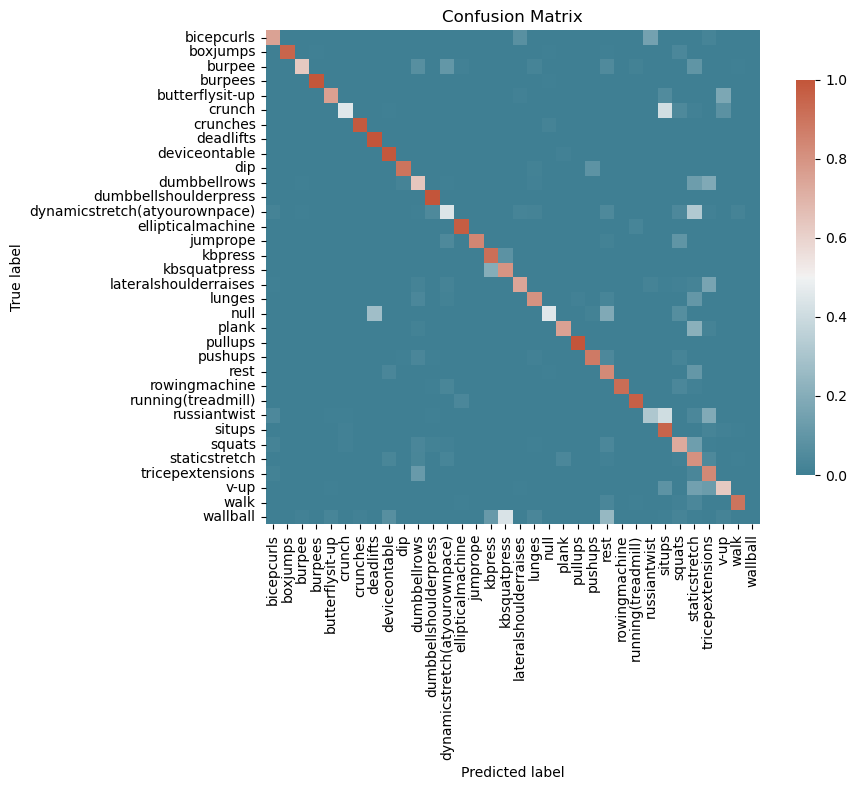

                               precision    recall  f1-score   support

                   bicepcurls       0.79      0.75      0.77       344
                     boxjumps       1.00      0.95      0.97       698
                       burpee       0.93      0.63      0.75       317
                      burpees       0.99      0.99      0.99       731
              butterflysit-up       0.93      0.76      0.83       377
                       crunch       0.80      0.45      0.58       226
                     crunches       0.99      0.98      0.99       556
                    deadlifts       0.91      1.00      0.95       762
                deviceontable       0.93      0.99      0.96      4514
                          dip       0.89      0.90      0.90       151
                 dumbbellrows       0.52      0.64      0.57       525
        dumbbellshoulderpress       0.89      1.00      0.94       592
dynamicstretch(atyourownpace)       0.68      0.44      0.54       823
     

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
model = IMUCNN(num_classes=num_classes, window_length=window_length)
model.load_state_dict(torch.load('models/best_model.pt', weights_only=True))
model.to(device)

# For evaluation with labels
test_preds, test_labels = predict(model, test_loader, device)
plot_confusion_matrix(test_labels, test_preds, class_names=list(label_encoder.classes_))

# For inference without labels
# inference_preds = predict(model, inference_dataloader, device)

In [16]:
# Get predictions
y_pred, y_true = predict(model, val_loader, device)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)



# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, labels=list(label_encoder.classes_)))


Classification Report:
                                precision    recall  f1-score   support

                   bicepcurls       0.00      0.00      0.00         0
                     boxjumps       0.00      0.00      0.00         0
                       burpee       0.00      0.00      0.00         0
                      burpees       0.00      0.00      0.00         0
              butterflysit-up       0.00      0.00      0.00         0
                       crunch       0.00      0.00      0.00         0
                     crunches       0.00      0.00      0.00         0
                    deadlifts       0.00      0.00      0.00         0
                deviceontable       0.00      0.00      0.00         0
                          dip       0.00      0.00      0.00         0
                 dumbbellrows       0.00      0.00      0.00         0
        dumbbellshoulderpress       0.00      0.00      0.00         0
dynamicstretch(atyourownpace)       0.00      0.00  

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pac

In [17]:
model

IMUCNN(
  (conv1): Conv1d(6, 64, kernel_size=(9,), stride=(1,), padding=(4,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(9,), stride=(1,), padding=(4,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(4,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4736, out_features=500, bias=True)
  (bn_fc1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=64, 

In [18]:
label_encoder.classes_

array(['bicepcurls', 'boxjumps', 'burpee', 'burpees', 'butterflysit-up',
       'crunch', 'crunches', 'deadlifts', 'deviceontable', 'dip',
       'dumbbellrows', 'dumbbellshoulderpress',
       'dynamicstretch(atyourownpace)', 'ellipticalmachine', 'jumprope',
       'kbpress', 'kbsquatpress', 'lateralshoulderraises', 'lunges',
       'null', 'plank', 'pullups', 'pushups', 'rest', 'rowingmachine',
       'running(treadmill)', 'russiantwist', 'situps', 'squats',
       'staticstretch', 'tricepextensions', 'v-up', 'walk', 'wallball'],
      dtype=object)